<a href="https://www.kaggle.com/code/randoeleven/fakenews-analysis-randomforest?scriptVersionId=161646185" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news/FakeNewsNet.csv


In [2]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.utils import to_categorical

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


2024-02-04 11:24:54.176589: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 11:24:54.176729: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 11:24:54.317648: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv('/kaggle/input/fake-news/FakeNewsNet.csv')
df

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1
...,...,...,...,...,...
23191,Pippa Middleton wedding: In case you missed it...,https://www.express.co.uk/news/royal/807049/pi...,www.express.co.uk,52,1
23192,Zayn Malik & Gigi Hadid’s Shocking Split: Why ...,hollywoodlife.com/2018/03/13/zayn-malik-gigi-h...,hollywoodlife.com,7,0
23193,Jessica Chastain Recalls the Moment Her Mother...,http://www.justjared.com/2018/01/17/jessica-ch...,www.justjared.com,26,1
23194,"Tristan Thompson Feels ""Dumped"" After Khloé Ka...",www.intouchweekly.com/posts/tristan-thompson-f...,www.intouchweekly.com,24,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23196 entries, 0 to 23195
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          23196 non-null  object
 1   news_url       22866 non-null  object
 2   source_domain  22866 non-null  object
 3   tweet_num      23196 non-null  int64 
 4   real           23196 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 906.2+ KB


In [5]:
source = df['source_domain'].value_counts()

In [6]:
source = df['source_domain'].value_counts().reset_index()

In [7]:
source

,source_domain,count
0,people.com,1786
1,www.dailymail.co.uk,964
2,en.wikipedia.org,741
3,www.usmagazine.com,709
4,www.etonline.com,666
...,...,...
2436,bioguide.congress.gov,1
2437,dailyheadlines.net,1
2438,www.duggarfamily.com,1
2439,www.naturallycurly.com,1


In [8]:
real = df[['real','source_domain']]

In [9]:
#make rename
real_1 = real[(real['real']==1)].value_counts().reset_index()
real_1 = real_1.drop('real', axis=1)
real_1 = real_1.rename(columns={'count': 'real'})

real_0 = real[(real['real']==0)].value_counts().reset_index()
real_0 =  real_0.drop('real', axis=1)
real_0 = real_0.rename(columns={'count': 'fake'})

In [10]:
real_1

,source_domain,real
0,people.com,1570
1,www.dailymail.co.uk,770
2,en.wikipedia.org,618
3,www.etonline.com,585
4,www.usmagazine.com,562
...,...,...
1892,myprofileblog25.blogspot.com,1
1893,mylittlecorneroflife.com,1
1894,myfashunpassion.blog,1
1895,my.charitywater.org,1


In [11]:
real_0

,source_domain,fake
0,hollywoodlife.com,460
1,people.com,216
2,www.dailymail.co.uk,194
3,radaronline.com,174
4,www.eonline.com,154
...,...,...
966,tigerbeat.com,1
967,tinybuddha.com,1
968,tmzbreaking.com,1
969,tnaty.lisboa.ltd,1


In [12]:
top_real = real_1.head(10)
top_fake = real_0.head(10)

In [13]:
top_real

,source_domain,real
0,people.com,1570
1,www.dailymail.co.uk,770
2,en.wikipedia.org,618
3,www.etonline.com,585
4,www.usmagazine.com,562
5,www.longroom.com,549
6,www.usatoday.com,300
7,www.hollywoodreporter.com,298
8,variety.com,259
9,ew.com,214


> # **Analysis Dataset**

Fake News by Domain

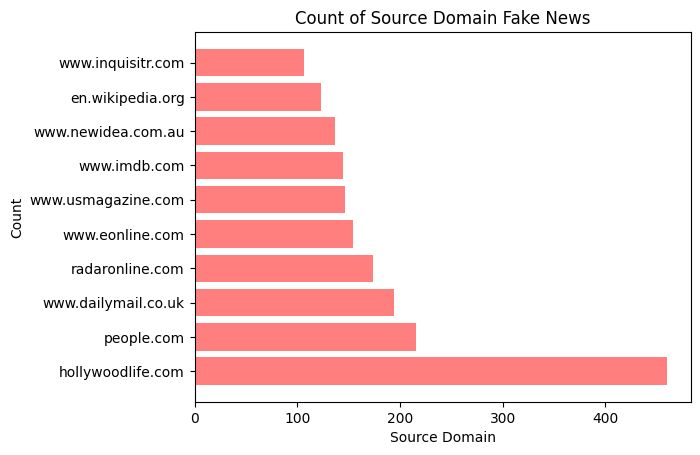

In [14]:
# Create a bar plot of the counts
plt.barh( top_fake['source_domain'],top_fake['fake'],color='red', alpha=0.5)
# Add labels and a title to the plot
plt.xlabel('Source Domain')
plt.ylabel('Count')
plt.title('Count of Source Domain Fake News')

# Show the plot
plt.show()

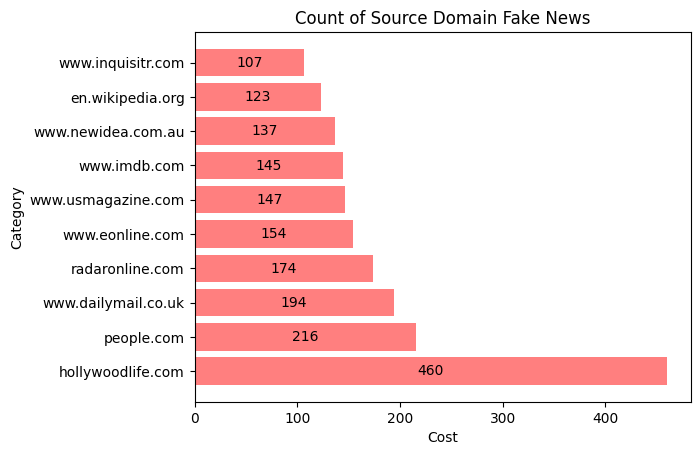

In [15]:
# First make a subplot, so that axes is available containing the function bar_label.
fig, ax = plt.subplots()
g=ax.barh(top_fake['source_domain'],top_fake['fake'],color='red', alpha=0.5)
ax.set_xlabel("Cost")
ax.set_ylabel("Category")
ax.bar_label(g, label_type="center") # This provides the labelling, this only available at higher version. You can do pip install -U matplotlib
plt.title('Count of Source Domain Fake News')

plt.show()

Count real news by domain

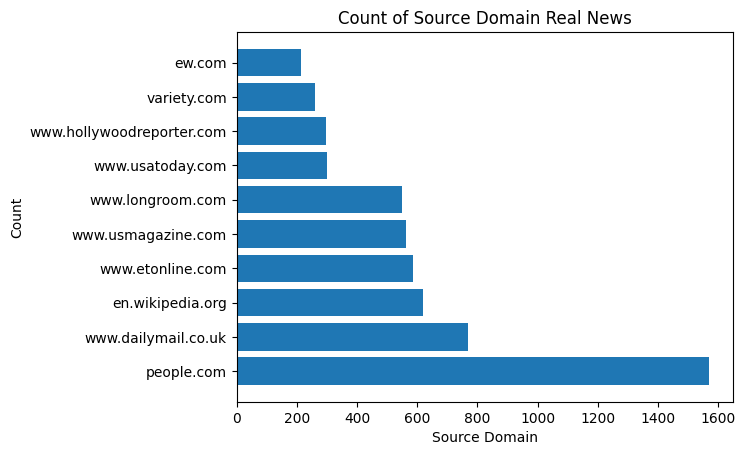

In [16]:
# Create a bar plot of the counts
plt.barh( top_real['source_domain'],top_real['real'])
# Add labels and a title to the plot
plt.xlabel('Source Domain')
plt.ylabel('Count')
plt.title('Count of Source Domain Real News')

# Show the plot
plt.show()

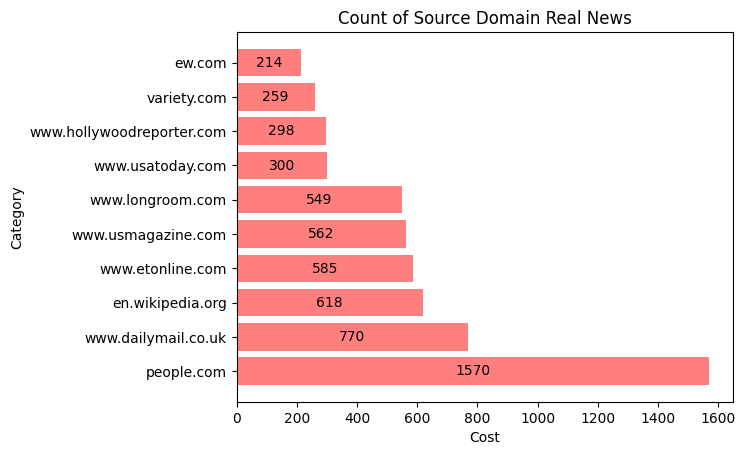

In [17]:
# First make a subplot, so that axes is available containing the function bar_label.
fig, ax = plt.subplots()
g=ax.barh(top_real['source_domain'],top_real['real'],color='red', alpha=0.5)
ax.set_xlabel("Cost")
ax.set_ylabel("Category")
plt.title('Count of Source Domain Real News')
ax.bar_label(g, label_type="center") # This provides the labelling, this only available at higher version. You can do pip install -U matplotlib
plt.show()

In [18]:
df_combined = pd.concat([real_1,real_0],ignore_index=True)
df_combined

,source_domain,real,fake
0,people.com,1570.0,NaN
1,www.dailymail.co.uk,770.0,NaN
2,en.wikipedia.org,618.0,NaN
3,www.etonline.com,585.0,NaN
4,www.usmagazine.com,562.0,NaN
...,...,...,...
2863,tigerbeat.com,NaN,1.0
2864,tinybuddha.com,NaN,1.0
2865,tmzbreaking.com,NaN,1.0
2866,tnaty.lisboa.ltd,NaN,1.0


> # **Visualization by tweet**

In [19]:
df_tweet = df.sort_values('tweet_num', ascending = False)

In [20]:
df_tweet

,title,news_url,source_domain,tweet_num,real
11489,The Legislative Process,https://www.house.gov/content/learn/legislativ...,www.house.gov,29060,0
21215,One in Four – Congressman Joe Pitts – Medium,https://medium.com/@RepJoePitts/one-in-four-66...,medium.com,27377,1
9505,Rep. Michael McCaul (R-TX) Appears on Face the...,http://us3.campaign-archive1.com/?u=468d5dc433...,us3.campaign-archive1.com,21182,1
21088,"Outlook, Office, Skype, Bing, Breaking News, a...",http://www.msnbc.msn.com/id/32935603/ns/meet_t...,www.msnbc.msn.com,19863,1
3379,interview on Fox News,http://www.cq.com/doc/newsmakertranscripts-431...,www.cq.com,17746,1
...,...,...,...,...,...
21416,Mike G.: After high school in the '60s I worke...,http://www.thesunchronicle.com/mike-g-after-hi...,www.thesunchronicle.com,0,1
961,Beyoncé and JAY-Z Have Bought a 400k A Month R...,https://www.harpersbazaar.com/celebrity/latest...,www.harpersbazaar.com,0,1
20320,Tyga Is Dating Kim Kardashian Look-Alike Kamil...,https://people.com/music/tyga-dating-kim-k-loo...,people.com,0,1
4537,Kourtney Kardashian Freezes Eggs So She Can Ha...,https://www.cosmopolitan.com/entertainment/cel...,www.cosmopolitan.com,0,1


In [21]:
df_tweet_top = df_tweet.head(10)

# Top Tweet by domain

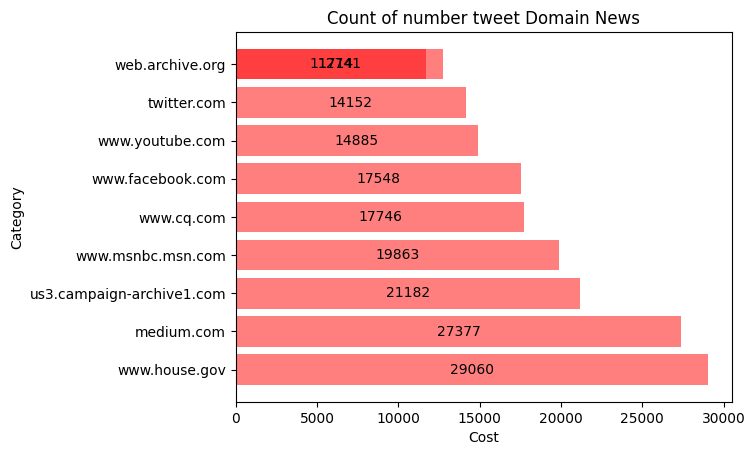

In [22]:
# First make a subplot, so that axes is available containing the function bar_label.
fig, ax = plt.subplots()
g=ax.barh(df_tweet_top['source_domain'],df_tweet_top['tweet_num'],color='red', alpha=0.5)
ax.set_xlabel("Cost")
ax.set_ylabel("Category")
plt.title('Count of number tweet Domain News')
ax.bar_label(g, label_type="center") # This provides the labelling, this only available at higher version. You can do pip install -U matplotlib
plt.show()

# Top Tweet news Real by Domain

In [23]:
df_tweet = df.sort_values('tweet_num', ascending = False)

In [24]:
#real news
df_tweet_real = df_tweet[df_tweet['real']==1]
df_tweet_real

,title,news_url,source_domain,tweet_num,real
21215,One in Four – Congressman Joe Pitts – Medium,https://medium.com/@RepJoePitts/one-in-four-66...,medium.com,27377,1
9505,Rep. Michael McCaul (R-TX) Appears on Face the...,http://us3.campaign-archive1.com/?u=468d5dc433...,us3.campaign-archive1.com,21182,1
21088,"Outlook, Office, Skype, Bing, Breaking News, a...",http://www.msnbc.msn.com/id/32935603/ns/meet_t...,www.msnbc.msn.com,19863,1
3379,interview on Fox News,http://www.cq.com/doc/newsmakertranscripts-431...,www.cq.com,17746,1
7788,"""One Hundred Percent"" by Club for Growth Action",https://www.youtube.com/watch?v=DZeKdfxI_RA,www.youtube.com,14885,1
...,...,...,...,...,...
21416,Mike G.: After high school in the '60s I worke...,http://www.thesunchronicle.com/mike-g-after-hi...,www.thesunchronicle.com,0,1
961,Beyoncé and JAY-Z Have Bought a 400k A Month R...,https://www.harpersbazaar.com/celebrity/latest...,www.harpersbazaar.com,0,1
20320,Tyga Is Dating Kim Kardashian Look-Alike Kamil...,https://people.com/music/tyga-dating-kim-k-loo...,people.com,0,1
4537,Kourtney Kardashian Freezes Eggs So She Can Ha...,https://www.cosmopolitan.com/entertainment/cel...,www.cosmopolitan.com,0,1


In [25]:
df_tweet_real = df_tweet_real.head(20)

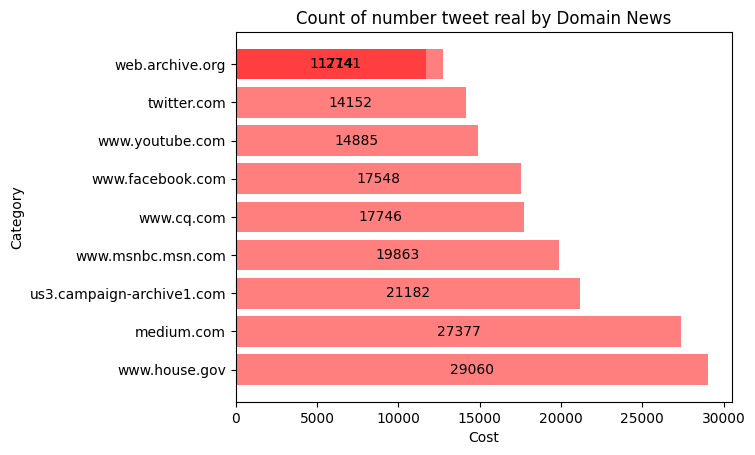

In [26]:
# First make a subplot, so that axes is available containing the function bar_label.
fig, ax = plt.subplots()
g=ax.barh(df_tweet_top['source_domain'],df_tweet_top['tweet_num'],color='red', alpha=0.5)
ax.set_xlabel("Cost")
ax.set_ylabel("Category")
plt.title('Count of number tweet real by Domain News')
ax.bar_label(g, label_type="center") # This provides the labelling, this only available at higher version. You can do pip install -U matplotlib
plt.show()

# Top Number tweet fake news by Domain

In [27]:
#real news
df_tweet_fake = df_tweet[df_tweet['real']==0]
df_tweet_fake

,title,news_url,source_domain,tweet_num,real
11489,The Legislative Process,https://www.house.gov/content/learn/legislativ...,www.house.gov,29060,0
18042,Wake Up America,https://www.facebook.com/StopDjTrump/photos/a....,www.facebook.com,17548,0
12631,Neon Nettle,http://www.neonnettle.com/videos/473-doctors-w...,www.neonnettle.com,6575,0
13286,SPECIAL REPORT: GEORGIA BECOMES FIRST STATE TO...,http://usnnetwork.com/special-report-georgia-b...,usnnetwork.com,6304,0
2873,Snapchat is shutting down!,http://www.breakingnews365.net/5a00d7972338f/s...,www.breakingnews365.net,5122,0
...,...,...,...,...,...
12014,"Royal rules: The dress, the bouquet and the ro...",www.cbsnews.com/news/royal-wedding-rules-the-d...,www.cbsnews.com,0,0
14044,Story About Why Beyonce Kim Kardashian Have...,NaN,NaN,0,0
5680,Opinion | Lena Dunham: Losing Birth Control Co...,www.nytimes.com/2017/06/09/opinion/lena-dunham...,www.nytimes.com,0,0
22121,I Read It So You Don't Have To: Lynne Spears' ...,ew.com/article/2008/10/01/i-read-it-so-yo-2/,ew.com,0,0


In [28]:
df_tweet_fake = df_tweet_fake.head(20)

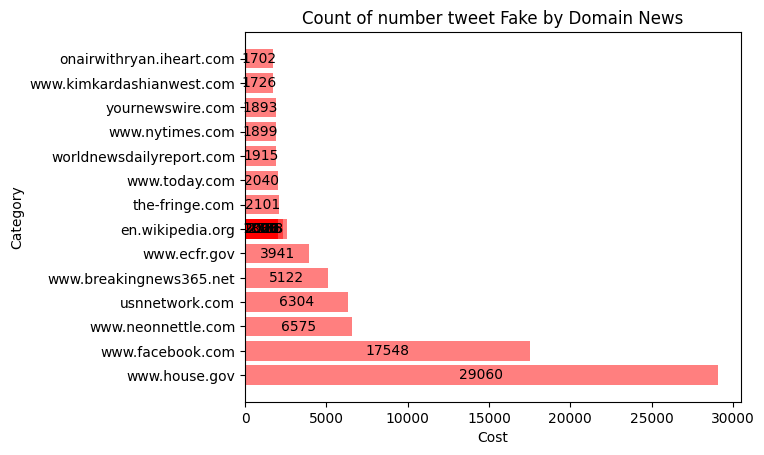

In [29]:
# First make a subplot, so that axes is available containing the function bar_label.
fig, ax = plt.subplots()
g=ax.barh(df_tweet_fake['source_domain'],df_tweet_fake['tweet_num'],color='red', alpha=0.5)
ax.set_xlabel("Cost")
ax.set_ylabel("Category")
plt.title('Count of number tweet Fake by Domain News')
ax.bar_label(g, label_type="center") # This provides the labelling, this only available at higher version. You can do pip install -U matplotlib
plt.show()

> # **Cleaning Data**

In [30]:
df

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1
...,...,...,...,...,...
23191,Pippa Middleton wedding: In case you missed it...,https://www.express.co.uk/news/royal/807049/pi...,www.express.co.uk,52,1
23192,Zayn Malik & Gigi Hadid’s Shocking Split: Why ...,hollywoodlife.com/2018/03/13/zayn-malik-gigi-h...,hollywoodlife.com,7,0
23193,Jessica Chastain Recalls the Moment Her Mother...,http://www.justjared.com/2018/01/17/jessica-ch...,www.justjared.com,26,1
23194,"Tristan Thompson Feels ""Dumped"" After Khloé Ka...",www.intouchweekly.com/posts/tristan-thompson-f...,www.intouchweekly.com,24,0


In [31]:
stopwords = nltk.corpus.stopwords.words("english")
lemmatizer = nltk.stem.WordNetLemmatizer()

In [32]:
nlp = spacy.load("en_core_web_sm")

In [33]:
def process_text(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower().strip() if token.lemma_ != "-PRON-" else token.lower_ for token in doc] #lower to font
    filtered_tokens = [token for token in tokens if token and token not in STOP_WORDS] #remove stopwords
    return " ".join(filtered_tokens) # combine the text

In [34]:
df_clean = df #move dataframe to df_clean
df_clean['pros']= df_clean['title'].apply(process_text) #apply def precess text to clean the text
df_clean

,title,news_url,source_domain,tweet_num,real,pros
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1,kandi burruss explodes rape accusation ' real ...
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1,people choice awards 2018 : good red carpet look
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1,sophia bush send sweet birthday message ' tree...
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1,colombian singer maluma spark rumour inappropr...
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1,gossip girl 10 year later : upper east siders ...
...,...,...,...,...,...,...
23191,Pippa Middleton wedding: In case you missed it...,https://www.express.co.uk/news/royal/807049/pi...,www.express.co.uk,52,1,pippa middleton wedding : case miss ... pippa ...
23192,Zayn Malik & Gigi Hadid’s Shocking Split: Why ...,hollywoodlife.com/2018/03/13/zayn-malik-gigi-h...,hollywoodlife.com,7,0,zayn malik & gigi hadid shocking split : ’ cha...
23193,Jessica Chastain Recalls the Moment Her Mother...,http://www.justjared.com/2018/01/17/jessica-ch...,www.justjared.com,26,1,jessica chastain recall moment mother boyfrien...
23194,"Tristan Thompson Feels ""Dumped"" After Khloé Ka...",www.intouchweekly.com/posts/tristan-thompson-f...,www.intouchweekly.com,24,0,"tristan thompson feel "" dump "" khloé kardashia..."


In [35]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_clean['title'])
df_clean['seq_title'] = tokenizer.texts_to_sequences(df_clean['title']) # sequence each word to number word

In [36]:
df_clean

,title,news_url,source_domain,tweet_num,real,pros,seq_title
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1,kandi burruss explodes rape accusation ' real ...,"[4634, 5276, 3809, 43, 1026, 5277, 7, 1596, 31..."
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1,people choice awards 2018 : good red carpet look,"[909, 306, 33, 22, 1, 60, 116, 152, 208]"
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1,sophia bush send sweet birthday message ' tree...,"[1597, 1082, 1719, 390, 99, 532, 3, 3241, 2835..."
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1,colombian singer maluma spark rumour inappropr...,"[7223, 481, 3810, 1310, 1311, 4, 5278, 105, 8,..."
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1,gossip girl 10 year later : upper east siders ...,"[976, 297, 179, 117, 1875, 21, 3242, 1945, 124..."
...,...,...,...,...,...,...,...
23191,Pippa Middleton wedding: In case you missed it...,https://www.express.co.uk/news/royal/807049/pi...,www.express.co.uk,52,1,pippa middleton wedding : case miss ... pippa ...,"[517, 154, 28, 5, 886, 40, 1289, 59, 517, 752,..."
23192,Zayn Malik & Gigi Hadid’s Shocking Split: Why ...,hollywoodlife.com/2018/03/13/zayn-malik-gigi-h...,hollywoodlife.com,7,0,zayn malik & gigi hadid shocking split : ’ cha...,"[816, 964, 308, 3152, 739, 74, 42, 3169, 6, 12..."
23193,Jessica Chastain Recalls the Moment Her Mother...,http://www.justjared.com/2018/01/17/jessica-ch...,www.justjared.com,26,1,jessica chastain recall moment mother boyfrien...,"[176, 2958, 1041, 1, 680, 11, 1765, 172, 24401..."
23194,"Tristan Thompson Feels ""Dumped"" After Khloé Ka...",www.intouchweekly.com/posts/tristan-thompson-f...,www.intouchweekly.com,24,0,"tristan thompson feel "" dump "" khloé kardashia...","[276, 307, 849, 1720, 13, 447, 16, 1565, 3, 12..."


> # **All word cloud**

**Word cloud by ALL tweet**

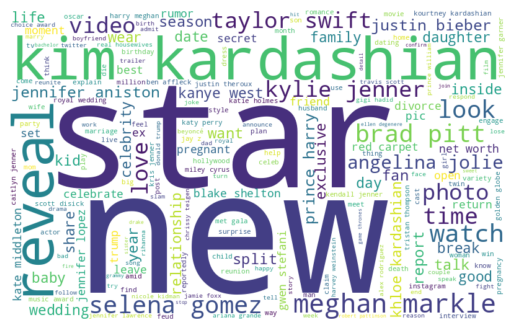

In [37]:
from wordcloud import WordCloud
# Join all the text data into a single string
text = ' '.join(df['pros'].tolist())


# Create a word cloud object
wordcloud = WordCloud(width=800, height=500, background_color='white').generate(text)


# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

In [38]:
#make rename
real_1_clean = df_clean[(df_clean['real']==1)].reset_index()
real_1_clean  = real_1_clean.drop('real', axis=1)
real_1_clean  = real_1_clean.rename(columns={'count': 'real'})

real_0_clean  = df_clean[(df_clean['real']==0)].reset_index()
real_0_clean  =  real_0_clean.drop('real', axis=1)
real_0_clean  = real_0_clean.rename(columns={'count': 'fake'})

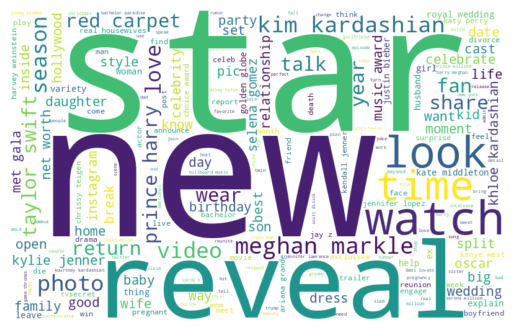

In [39]:
#Word cloud real news

# Join all the text data into a single string
text = ' '.join(real_1_clean['pros'].tolist())

# Create a word cloud object
wordcloud = WordCloud(width=800, height=500, background_color='white').generate(text)


# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

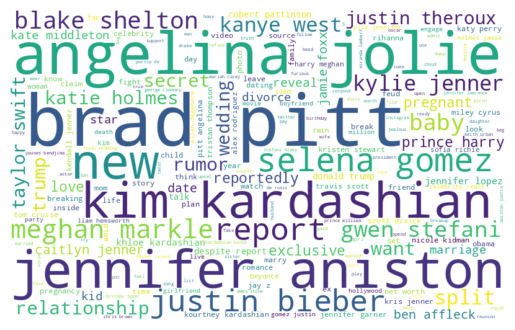

In [40]:
#Word cloud real news

# Join all the text data into a single string
text = ' '.join(real_0_clean['pros'].tolist())

# Create a word cloud object
wordcloud = WordCloud(width=800, height=500, background_color='white').generate(text)


# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

# model by Title and Label

In [41]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_clean['title'])
seq = tokenizer.texts_to_sequences(df_clean['title']) # sequence each word to number word

In [42]:
input_pad_sequences= pad_sequences(seq,maxlen=10 ,padding= 'pre')

In [43]:
X = input_pad_sequences
y = df['real']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
print(len(X_train))

18556


In [45]:
y_train.shape

(18556,)

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score,f1_score,accuracy_score,precision_score

In [47]:
# optionally scale the features

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_train)

In [48]:
from sklearn.ensemble import RandomForestClassifier
# create and fit the Random Forest classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_scaled, y_train)

RandomForestClassifier(random_state=42)

In [49]:
# make predictions on the training set
y_train_pred = classifier.predict(X_scaled)

# evaluate performance on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# make predictions on the test set
X_test_scaled = scaler.transform(X_test)
y_test_pred = classifier.predict(X_test_scaled)

# evaluate performance on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

In [50]:
print("Train Model")
print("===================================")
print("Train Accuracy : ",train_accuracy)
print("Train Precision : ",train_precision)
print("Train Recall : ",train_recall)
print("Train F1 Score : ",train_f1)

print()
print("Test Model")
print("===================================")
print("Test Accuracy : ",test_accuracy)
print("Test Precision : ",test_precision)
print("Test Recall : ",test_recall)
print("Train F1 Score : ",test_f1)


Train Model
Train Accuracy :  0.9949342530717827
Train Precision :  0.9950629650829994
Train Recall :  0.9982055699109963
Train F1 Score :  0.9966317901676938

Test Model
Test Accuracy :  0.7814655172413794
Test Precision :  0.7859271143708457
Test Recall :  0.9772014819036763
Train F1 Score :  0.8711890243902439
